In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
IMAGE_SIZE=254
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/DatasetMake",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE)

Found 4220 files belonging to 4 classes.


In [4]:
class_names=dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

(32, 254, 254, 3)
[0 2 0 0 3 0 1 2 0 2 0 2 3 3 1 2 0 0 0 2 2 2 0 0 0 1 3 3 0 3 0 1]


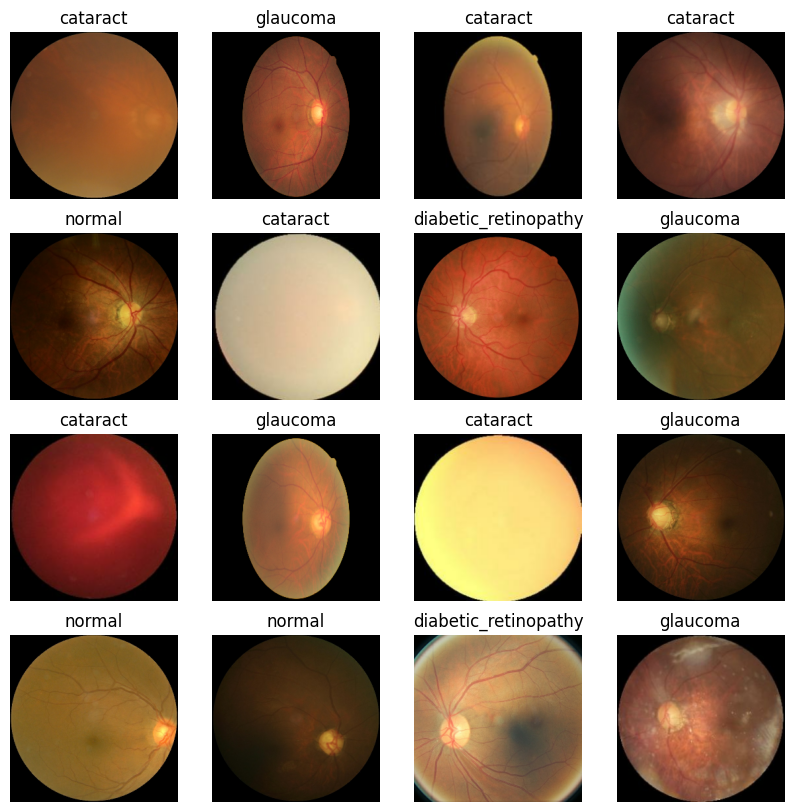

In [5]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=6)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.00392157 0.01176471 0.00784314]
  [0.00597499 0.01381813 0.00989656]
  [0.01176471 0.01176471 0.00392157]
  ...
  [0.0098348  0.01176471 0.00199166]
  [0.01075417 0.01075417 0.01075417]
  [0.01176471 0.00784314 0.02745098]]

 [[0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01568628 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01568628 0.01568628 0.01005823]
  [0.01470807 0.01470807 0.01470807]
  [0.0098348  0.00695611 0.02343532]]

 [[0.01176471 0.01176471 0.01176471]
  [0.00784314 0.01568628 0.01176471]
  [0.00784314 0.01568628 0.01176471]
  ...
  [0.01780144 0.01780144 0.02008316]
  [0.01381812 0.01381812 0.01381812]
  [0.00784314 0.01176471 0.01960784]]

 ...

 [[0.02536912 0.01485905 0.02144755]
  [0.01164118 0.02642877 0.01511092]
  [0.0099583  0.03348771 0.02398041]
  ...
  [0.02481249 0.03966668 0.05309556]
  [0.02675212 0.02880554 0.03652517]
  [0.02757449 0.01587153 0.01801515]]

 [[0.01773969 0.01761619 0.02355883]
  [0.0047145  0.02647277 0.00186815]


In [10]:
resizing_and_rescaling=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),layers.experimental.preprocessing.Rescaling(1.0/255)])
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2)])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5
model=models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 254, 254, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 254, 254, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 252, 252, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (32, 250, 250, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2  (32, 125, 125, 128)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 123, 123, 128)       147584    
                                                      

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
105/105 [==============================] - 911s 989ms/step - loss: 1.3738 - accuracy: 0.3045 - val_loss: 1.0825 - val_accuracy: 0.5144
Epoch 2/50
105/105 [==============================] - 52s 499ms/step - loss: 0.9733 - accuracy: 0.5283 - val_loss: 0.9497 - val_accuracy: 0.5240
Epoch 3/50
105/105 [==============================] - 52s 493ms/step - loss: 0.8445 - accuracy: 0.5921 - val_loss: 0.8919 - val_accuracy: 0.5721
Epoch 4/50
105/105 [==============================] - 52s 497ms/step - loss: 0.7732 - accuracy: 0.6275 - val_loss: 0.7296 - val_accuracy: 0.6611
Epoch 5/50
105/105 [==============================] - 51s 490ms/step - loss: 0.7183 - accuracy: 0.6690 - val_loss: 0.7228 - val_accuracy: 0.6442
Epoch 6/50
105/105 [==============================] - 51s 490ms/step - loss: 0.6788 - accuracy: 0.6725 - val_loss: 0.7037 - val_accuracy: 0.6923
Epoch 7/50
105/105 [==============================] - 51s 490ms/step - loss: 0.6862 - accuracy: 0.6704 - val_loss: 0.6431 - val_a

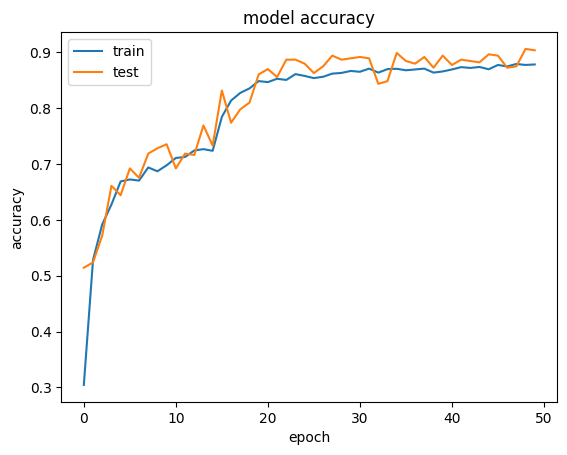

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

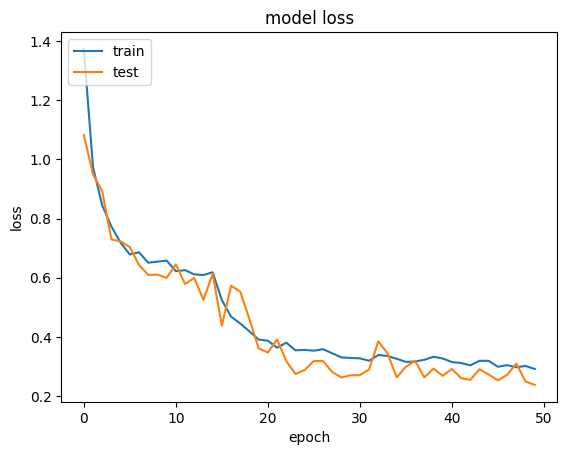

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [17]:
scores=model.evaluate(test_ds)

14/14 [==============================] - 35s 152ms/step - loss: 0.2921 - accuracy: 0.9085


In [18]:
import numpy as np

In [19]:
def predict (model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


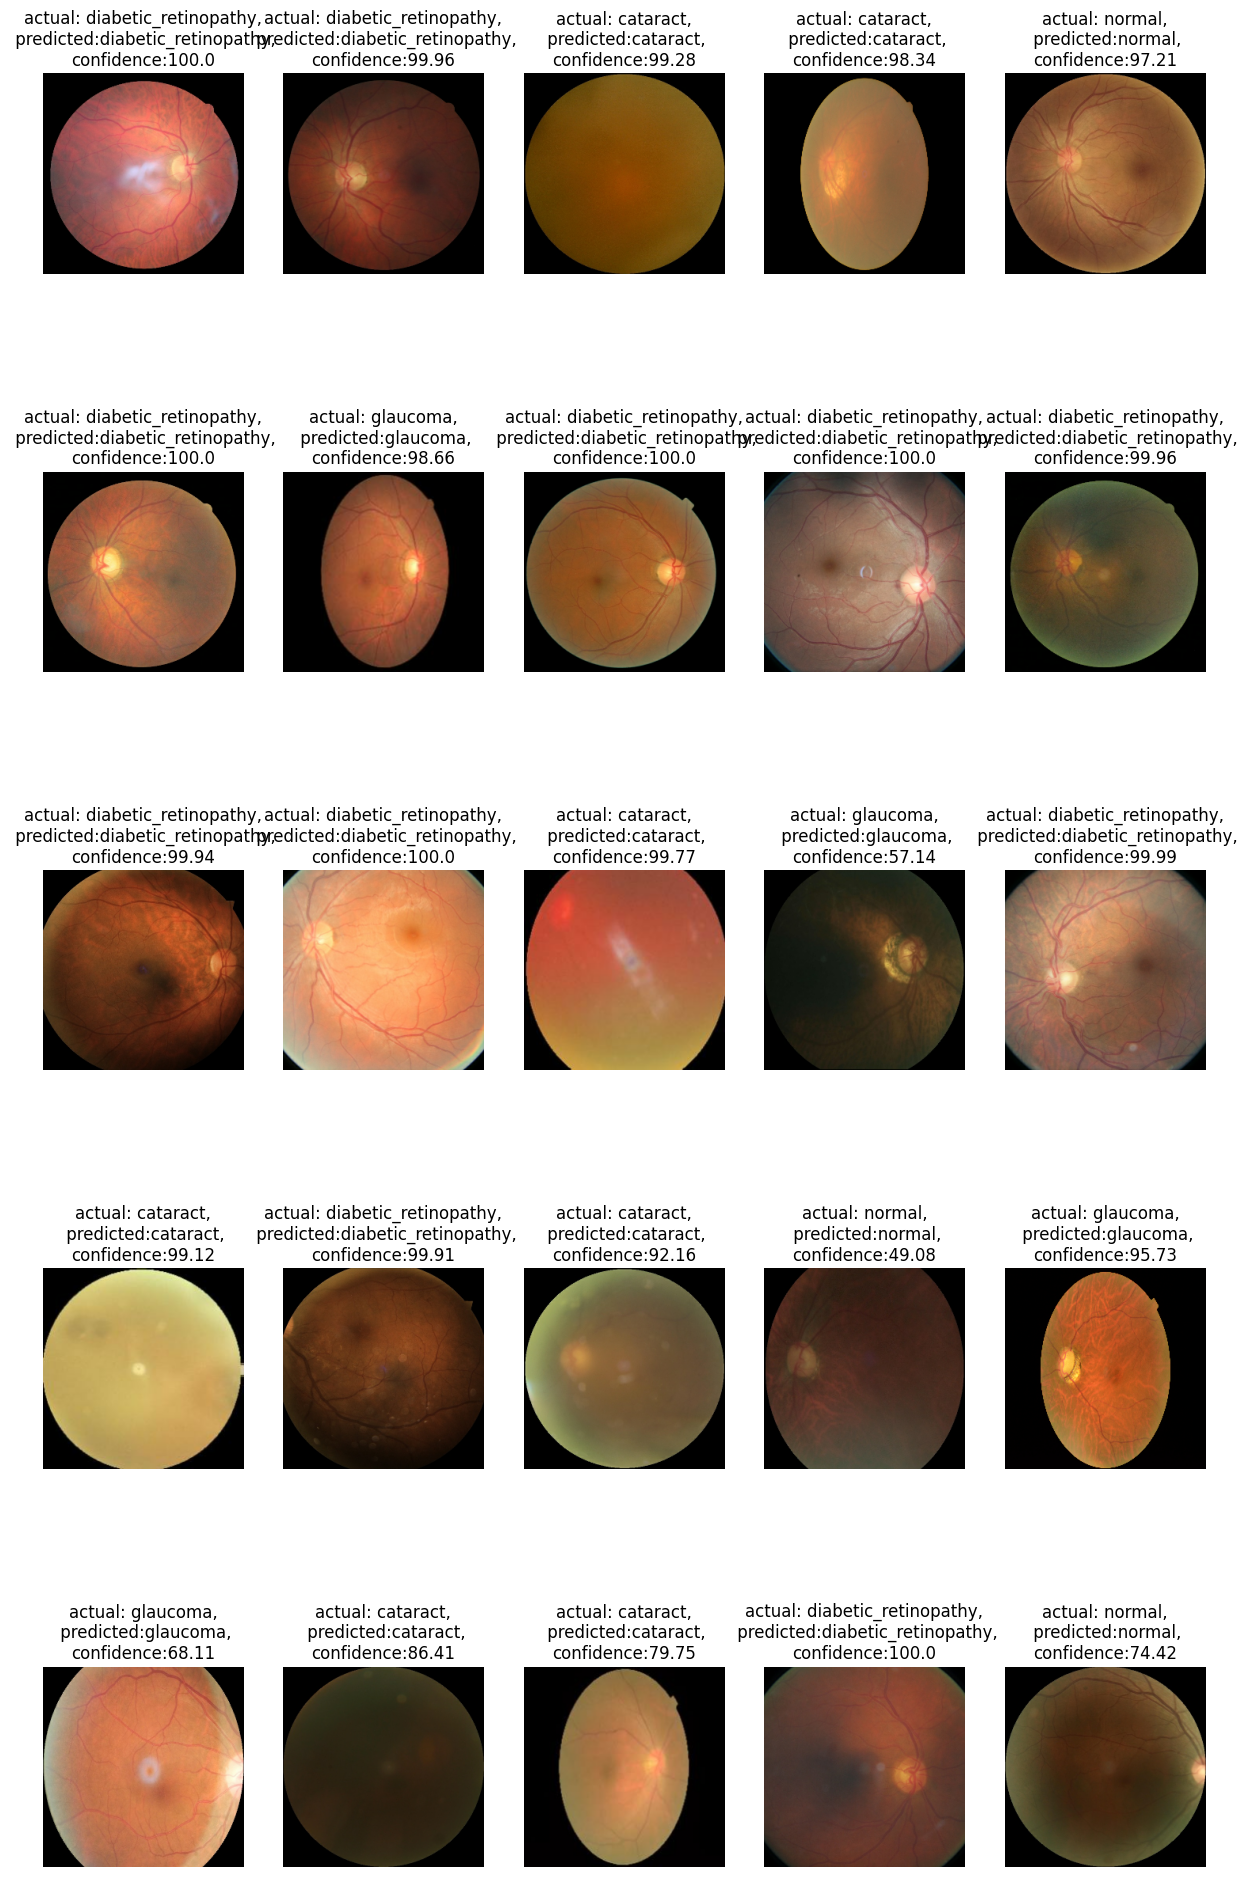

In [24]:
plt.figure(figsize=(15,25))
for images,labels in test_ds.take(1):
  for i in range(25):
    axisx=plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
    plt.axis("off")